# **Septin Segmentation** Notebook for QFM2025 Course

This notebook provides a workflow for **segmenting septin rings in microscopy images**. It includes steps for dataset preparation, model training, and prediction using YOLOv8, with customizable options to fine-tune the detection process. Designed specifically for the **QFM2025 course**, it aims to make object detection in pSTORM data.

contact: amin.zehtabian@fu-berlin.de
Last Update: Jan 2025

###GPU Check + Installing necessary libraries


Execute this cell to verify **GPU** access and install some necessary **libraries**.

Note: To use a better GPU, go to the toolbar, select **Runtime**, and switch the Runtime Type to one of the available GPU options

In [ ]:
!nvidia-smi
from matplotlib import image
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
#from IPython import display
#display.clear_output()
#from IPython.display import display, Image
import glob
import random
import os
!pip install tqdm   # for progress bar
from tqdm.notebook import tqdm
HOME = os.getcwd();
import torch
#display(HOME)


Wed Jan 29 22:43:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   44C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Optional: Mount **Google Drive** and get the current working directory.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#@markdown ###Path to the project (where the data and final models should be stored):
project_path = '/content/Project_Septin'#@param {type:"string"}

import os
#%cd project_path
!mkdir {project_path}
os.chdir(project_path)
HOME = os.getcwd()

# Installing YOLOv8

We are now ready to use the YOLOv8 model for training on our annotated images. **YOLOv8** supports a variety of prediction tasks, including:

- **Detection**: Drawing bounding boxes around objects.
- **Segmentation**: Outlining objects in an image.
- **Tracking**: Following objects across frames in a video.
- **Image Classification**: Categorizing images into predefined classes.
- **Pose Detection**: Estimating keypoints for human or object poses.

For our project, the focus will be on the **Segmentation of Septin Rings** (previously, we addressed detection of rings). You can find examples and additional resources on the Ultralytics GitHub page ((https://github.com/ultralytics/ultralytics))

In [ ]:
%pip install ultralytics --quiet
import ultralytics
ultralytics.checks()

Ultralytics 8.3.69 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Setup complete ✅ (12 CPUs, 53.0 GB RAM, 32.9/235.7 GB disk)


# Run Standard Pre-Trained YOLO Models on the Test Image

- Create a sub-folder named 'test' within your project folder (default: 'Project_Septin/test/').
- Place example test images into this folder.
- This cell runs a standard pre-trained YOLOv8 model on the test images. However, since the model has not been trained on data similar to your septin images, you will observe that no detection or segmentation is performed on these images.

/content

image 1/1 /content/Project_Septin/test/test.jpg: 640x640 (no detections), 8.1ms
Speed: 15.2ms preprocess, 8.1ms inference, 80.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/Project_Septin/test/test.jpg: 640x640 (no detections), 8.3ms
Speed: 3.5ms preprocess, 8.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


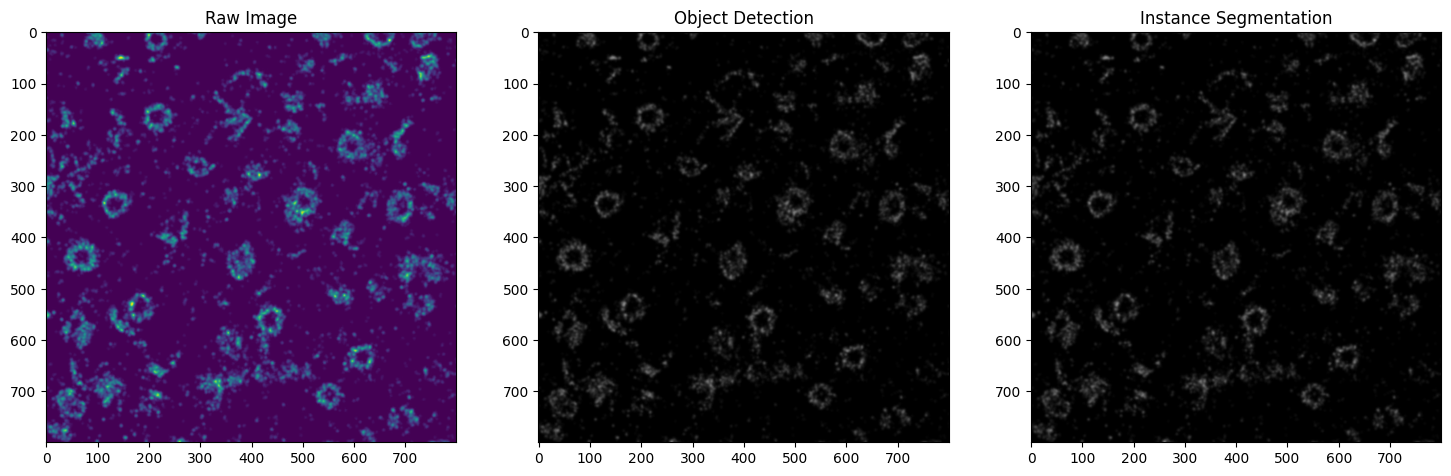

In [ ]:
from ultralytics import YOLO

#%cd {HOME}/test
Test_Image1 = '/content/Project_Septin/test/test.jpg'
#plt.imshow(image.imread(Test_Image1))

%cd {HOME}
# Standard pre-trained model for detection
model_detection = YOLO('yolov8n.pt')
# Standard pre-trained model for segmentation
model_segmentation = YOLO('yolov8n-seg.pt')

# Run the standard pre-trained models for detection and segmentation
prediction_detection = model_detection.predict(Test_Image1)
prediction_segmentation = model_segmentation.predict(Test_Image1)
# Visualization
detection_result_array = prediction_detection[0].plot()
instance_result_array = prediction_segmentation[0].plot()


fig = plt.figure(figsize=(18, 9))
ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Raw Image")
plt.imshow(image.imread(Test_Image1))
ax2 = fig.add_subplot(1,3,2)
ax2.set_title("Object Detection")
ax2.imshow(detection_result_array)
ax3 = fig.add_subplot(1,3,3)
ax3.set_title("Instance Segmentation")
ax3.imshow(instance_result_array)

# Training → Step #1: Importing the Training Dataset from Roboflow

To enable the model to recognize microscopy images containing septin rings, we need to train the model further (also known as **fine-tuning**) using a suitable training dataset. If you don’t have a pre-existing dataset, you will need to create one and annotate the training images.

There are several tools available for annotating objects in images, and the choice of tool depends on the type of annotation required. For example, annotations for object detection differ from those needed for segmentation. One of the simplest and most effective tools for annotation is **Roboflow** (https://roboflow.com/).

To help you get started, I have prepared a PowerPoint file with detailed instructions on creating training samples. Once you have created a custom training dataset using Roboflow, simply copy and paste your **API_KEY** into the code below to integrate it into your project.

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets
!pip install roboflow --quiet

from roboflow import Roboflow
rf = Roboflow(api_key="0o69ClS8r4Cwtju09p6Y")
project = rf.workspace("agewers-30oij").project("test-qe4xb")
version = project.version(1)
dataset = version.download("yolov8")

/content/Project_Septin/datasets
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 45.3 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to test-1 in yolov8:: 100%|██████████| 127/127 [00:00<00:00, 7461.29it/s]


# Training → Step #2: Modifying the data.yaml file

The training dataset has been successfully imported from the Roboflow cloud repository.

**Note 1:**
You can access the training, validation, and test images under the folder '**/datasets/**'. Detailed information about the datasets, such as paths and class labels, can be found in the file **data.yaml**.

**Note 2:**
In some versions of YOLOv8, you might encounter an error indicating that the model cannot locate the training and validation folders. To resolve this issue, open the **data.yaml** file and make a small modification. Update the paths to the following training and validation datasets to ensure they are correctly referenced:

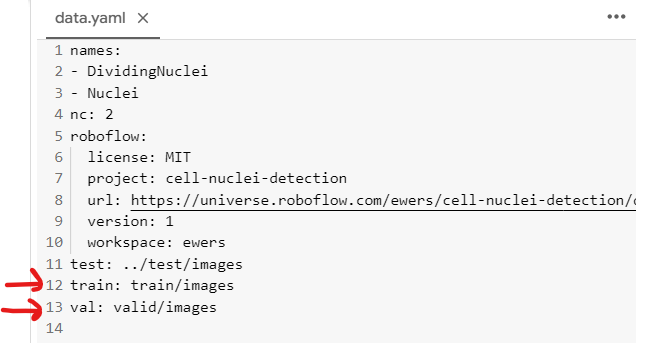

# Training → Step #3: Parameter Setting for Training

Here we need to set some training parameters, including the exact **YOLOv8 pre-trained segmentation model** we are going to fune-tune further.

We may begin training with the **YOLOv8s-seg.pt model**, which is the "small" version of YOLOv8 designed for object segmentation. This model provides a balance between speed and accuracy, making it suitable for many applications.

Note:
You are welcome to experiment with other YOLOv8 models based on your requirements:

Less complex models:
- YOLOv8n-seg.pt (nano): Prioritizes speed and efficiency, suitable for resource-constrained environments.

More complex models:
- YOLOv8m-seg.pt (medium): Offers improved accuracy at the cost of slightly higher computational requirements.
- YOLOv8l-seg.pt (large): Focuses on higher accuracy and is suitable for high-powered setups.
- YOLOv8x-seg.pt (extra-large): Provides the best accuracy but requires significant computational resources.

I suggest testing different **training parameters & settings** such as the number of epochs, image size, etc.


In [ ]:


#Training_source = base_path + "/data/Stardist/Training - Images" #@param {type:"string"}
#Training_target = base_path + "/data/Stardist/Training - Masks" #@param {type:"string"}

#@markdown ###Name and path to the final trained model:

trained_model_name = "SeptinDetection_Model1_ep50" #@param {type:"string"}

trained_model_path = project_path + "/Models" #@param {type:"string"}
#trained_model = model_path

#project_folder_name = 'CytoYOLOv8_RectLabel' #@param {type:"string"}
#result_folder_name = 'SemiSparse_modelS_ep200_ba8_'#@param {type:"string"}

#@markdown ### Choose between the pretrained YOLO detection models (n-seg, s-seg, m-seg, l-seg, x-seg):
YOLO_model_type= 'm-seg'#@param {type:"string"}
#@markdown ### Other parameters for training:
epochs =  100#@param {type:"number"}
batch_size =  4#@param {type:"number"}
initial_learning_rate = 0.01#@param {type:"number"}
patch_width = 200#@param {type:"number"}
patch_height = 200#@param {type:"number"}
imgsz = (patch_width,patch_height)

# Training → Step #4: Model Training

Finally, it's time for training (fine-tuning) the YOLOv8 on our data!

In [ ]:
from ultralytics import YOLO

optimizer = 'auto' # SGD, Adam, AdamW, NAdam, RAdam, RMSProp or auto
plots= True  # Generates and saves plots of training and validation metrics, as well as prediction examples
#model = YOLO('yolov8n.pt')  # load a pretrained YOLO detection model (n, s, m, l , x)
model_pt = 'yolov8'+YOLO_model_type+'.pt'
model = YOLO(model_pt)
#@markdown ###Path to the YAML file
yaml_address = '/content/Project_Septin/datasets/test-1/data.yaml'#@param {type:"string"}
model.train(data=yaml_address, epochs=epochs, batch=batch_size, lr0= initial_learning_rate, imgsz=imgsz, save=True, pretrained=True,optimizer=optimizer, plots = plots)  # train the model

100%|██████████| 52.4M/52.4M [00:01<00:00, 44.3MB/s]

Ultralytics 8.3.69 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=/content/Project_Septin/datasets/test-1/data.yaml, epochs=100, time=None, patience=100, batch=4, imgsz=(200, 200), save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

100%|██████████| 755k/755k [00:00<00:00, 101MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 327MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=200'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'
WARNING ⚠️ imgsz=[200] must be multiple of max stride 32, updating to [224]


train: Scanning /content/Project_Septin/datasets/test-1/train/labels... 55 images, 3 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<00:00, 1184.43it/s]

train: New cache created: /content/Project_Septin/datasets/test-1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/Project_Septin/datasets/test-1/valid/labels... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 672.27it/s]

val: New cache created: /content/Project_Septin/datasets/test-1/valid/labels.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs/segment/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.965G      2.025      2.546      3.705      1.012          4        224: 100%|██████████| 14/14 [00:03<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

                   all          4         24     0.0268      0.708     0.0444     0.0217     0.0268      0.708     0.0453     0.0279



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.954G      2.352      5.304      14.89     0.9767         12        224: 100%|██████████| 14/14 [00:01<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]

                   all          4         24      0.278      0.417      0.325     0.0628     0.0415      0.167     0.0154    0.00206



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.971G      2.972      5.248      18.37       1.13         12        224: 100%|██████████| 14/14 [00:01<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.22it/s]

                   all          4         24     0.0366      0.125     0.0243     0.0132     0.0592     0.0417      0.017    0.00368



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.969G      2.327      3.166      3.286     0.9901         17        224: 100%|██████████| 14/14 [00:01<00:00,  9.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]

                   all          4         24      0.312      0.417      0.249      0.134      0.249      0.333      0.186     0.0577



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.967G      1.917      2.092      2.912      0.949          4        224: 100%|██████████| 14/14 [00:01<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]

                   all          4         24      0.219      0.667      0.287      0.129     0.0685      0.208     0.0477     0.0242



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.967G      2.204      1.783      2.289     0.9479          7        224: 100%|██████████| 14/14 [00:01<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.96it/s]

                   all          4         24     0.0919     0.0417      0.028     0.0147     0.0918     0.0417      0.044     0.0101



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.967G      1.908      3.083      1.764     0.8925          7        224: 100%|██████████| 14/14 [00:01<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.70it/s]

                   all          4         24      0.145      0.458     0.0758     0.0207     0.0535       0.25     0.0288    0.00738



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.973G      2.521      4.566      1.588       1.02         31        224: 100%|██████████| 14/14 [00:01<00:00, 10.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.71it/s]

                   all          4         24      0.106      0.625      0.108     0.0295     0.0634      0.375     0.0559    0.00949



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.975G      2.214      4.048      1.648     0.9668         22        224: 100%|██████████| 14/14 [00:01<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]

                   all          4         24     0.0224      0.542     0.0211     0.0104     0.0207        0.5     0.0201    0.00553



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.956G      1.747       2.67       1.64     0.8894          8        224: 100%|██████████| 14/14 [00:01<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.64it/s]

                   all          4         24     0.0378      0.625     0.0473     0.0222     0.0277      0.458     0.0259    0.00671



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.954G      1.829      2.288      1.595     0.9078         22        224: 100%|██████████| 14/14 [00:01<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]

                   all          4         24     0.0849      0.708     0.0727     0.0251     0.0538      0.583      0.043     0.0127



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.958G      1.671      1.601      1.425     0.8632         30        224: 100%|██████████| 14/14 [00:01<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]

                   all          4         24     0.0228      0.833     0.0228     0.0134     0.0205       0.75     0.0189    0.00664



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.958G      1.537      1.259      1.271     0.8702         16        224: 100%|██████████| 14/14 [00:01<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.26it/s]

                   all          4         24     0.0275      0.875     0.0278     0.0146     0.0255      0.833     0.0237    0.00875



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.956G      1.315      1.367       1.42       0.85         10        224: 100%|██████████| 14/14 [00:01<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]

                   all          4         24     0.0275      0.875     0.0278     0.0146     0.0255      0.833     0.0237    0.00875



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.958G      1.447      1.176      1.346     0.8455         12        224: 100%|██████████| 14/14 [00:01<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.59it/s]

                   all          4         24     0.0117      0.583     0.0133    0.00547       0.01        0.5     0.0076    0.00283



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      0.96G      1.408      1.611      1.225     0.8407         18        224: 100%|██████████| 14/14 [00:01<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]

                   all          4         24     0.0264      0.542     0.0248     0.0154     0.0251        0.5     0.0207    0.00879



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      0.96G       1.32      1.896      1.205     0.8631          7        224: 100%|██████████| 14/14 [00:01<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.28it/s]

                   all          4         24     0.0228      0.458     0.0179     0.0111     0.0228      0.458     0.0178    0.00815



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      0.96G      1.458       1.77      1.084     0.8704         11        224: 100%|██████████| 14/14 [00:01<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.56it/s]


                   all          4         24     0.0291      0.583     0.0282     0.0164      0.027      0.542     0.0256    0.00853

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      0.96G      1.401      1.507      1.038     0.8455         15        224: 100%|██████████| 14/14 [00:01<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.52it/s]


                   all          4         24     0.0339      0.292     0.0237      0.013     0.0204      0.375     0.0163    0.00572

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      0.96G      1.391      1.456      1.042     0.8613         28        224: 100%|██████████| 14/14 [00:01<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.84it/s]

                   all          4         24      0.346      0.333       0.29      0.201      0.315       0.25      0.258     0.0999



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      0.96G      1.391      1.348      1.042     0.8334         19        224: 100%|██████████| 14/14 [00:01<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]

                   all          4         24     0.0638      0.708     0.0783     0.0392     0.0528      0.833     0.0474     0.0175



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.958G      1.175       1.26     0.9461      0.826         16        224: 100%|██████████| 14/14 [00:01<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]

                   all          4         24     0.0638      0.708     0.0783     0.0392     0.0528      0.833     0.0474     0.0175



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      0.96G      1.375      1.375      1.083     0.8596          5        224: 100%|██████████| 14/14 [00:01<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.60it/s]

                   all          4         24      0.622      0.875      0.805      0.529      0.592      0.833      0.715      0.247



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      0.96G      1.262      1.248      0.933     0.8376         20        224: 100%|██████████| 14/14 [00:01<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]

                   all          4         24       0.84      0.792      0.895      0.608      0.806       0.75      0.853      0.265



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      0.96G      1.245      1.201     0.9238     0.8292         12        224: 100%|██████████| 14/14 [00:01<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]

                   all          4         24      0.823      0.792      0.889      0.636      0.823      0.792      0.889      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      0.96G      1.258      1.378     0.9021     0.8195         21        224: 100%|██████████| 14/14 [00:01<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]

                   all          4         24      0.684      0.904      0.867      0.527      0.623      0.833      0.751      0.244



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      0.96G      1.213      1.277      0.907     0.8582         25        224: 100%|██████████| 14/14 [00:01<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.62it/s]

                   all          4         24      0.751      0.879      0.878      0.553      0.643      0.751      0.703      0.262



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      0.96G      1.169      1.347     0.8315     0.8438         21        224: 100%|██████████| 14/14 [00:01<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.01it/s]

                   all          4         24      0.794      0.875       0.88      0.625      0.756      0.833      0.814      0.296



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      0.96G      1.174      1.039     0.8891     0.8016         15        224: 100%|██████████| 14/14 [00:01<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]

                   all          4         24      0.866      0.807      0.886      0.651      0.772       0.75      0.755      0.275



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      0.96G      1.151      1.189      0.923     0.8313         10        224: 100%|██████████| 14/14 [00:01<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.74it/s]

                   all          4         24      0.866      0.807      0.886      0.651      0.772       0.75      0.755      0.275



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.958G      1.245      1.001     0.9439     0.8222          9        224: 100%|██████████| 14/14 [00:01<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.30it/s]

                   all          4         24      0.734      0.875      0.852      0.544      0.685       0.75      0.766       0.29



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.958G      1.168      1.062      0.908      0.817         35        224: 100%|██████████| 14/14 [00:01<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]

                   all          4         24      0.747      0.917      0.838      0.527      0.671      0.792      0.733      0.265



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.958G      1.162     0.9737     0.8383     0.8255         16        224: 100%|██████████| 14/14 [00:01<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.79it/s]

                   all          4         24      0.772      0.917      0.861      0.624      0.737      0.875      0.805      0.305



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      0.96G      1.091      1.161     0.8018     0.8209         26        224: 100%|██████████| 14/14 [00:01<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]

                   all          4         24      0.836      0.833      0.895      0.655      0.836      0.833      0.895      0.336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.958G       1.12     0.9412     0.8316     0.8376         16        224: 100%|██████████| 14/14 [00:01<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]

                   all          4         24      0.869      0.875      0.903      0.674      0.869      0.875      0.903      0.381



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.958G      1.012      1.155     0.8754     0.8163         16        224: 100%|██████████| 14/14 [00:01<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]

                   all          4         24      0.704      0.917       0.87      0.618      0.704      0.917       0.87       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.958G       1.06       1.15     0.8364     0.8277          9        224: 100%|██████████| 14/14 [00:01<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.07it/s]

                   all          4         24      0.736      0.958      0.882      0.646      0.736      0.958      0.882      0.311



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.956G      1.135      1.285     0.8697     0.8429         20        224: 100%|██████████| 14/14 [00:01<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]

                   all          4         24      0.736      0.958      0.882      0.646      0.736      0.958      0.882      0.311



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.958G      1.142       1.33     0.8425      0.827         14        224: 100%|██████████| 14/14 [00:01<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]

                   all          4         24      0.712      0.824      0.857      0.637      0.712      0.824      0.857      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.958G      1.066      1.251     0.7667     0.8144         28        224: 100%|██████████| 14/14 [00:01<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.97it/s]

                   all          4         24      0.666      0.875      0.832      0.621      0.666      0.875      0.832      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.958G      1.168       1.09     0.8441     0.8215         11        224: 100%|██████████| 14/14 [00:01<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]

                   all          4         24      0.629      0.833      0.811      0.568      0.758      0.651       0.78      0.337



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.958G      1.133      1.263     0.7988     0.8089         12        224: 100%|██████████| 14/14 [00:01<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.50it/s]

                   all          4         24       0.74      0.667      0.789      0.551       0.74      0.667      0.757      0.323



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      0.96G      1.144      1.145     0.8868     0.8366         11        224: 100%|██████████| 14/14 [00:01<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.67it/s]

                   all          4         24      0.633      0.792      0.784      0.591      0.692      0.749      0.758      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      0.96G      1.048     0.9873     0.8016     0.8145         21        224: 100%|██████████| 14/14 [00:01<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]

                   all          4         24      0.699      0.773      0.803      0.634      0.699      0.773      0.778      0.374



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      0.96G      1.136      1.314       0.82     0.8295         14        224: 100%|██████████| 14/14 [00:01<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.62it/s]

                   all          4         24      0.831       0.75      0.832      0.644      0.831       0.75      0.806      0.391



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      0.96G      1.058      1.231     0.8504     0.8427          5        224: 100%|██████████| 14/14 [00:01<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]

                   all          4         24      0.831       0.75      0.832      0.644      0.831       0.75      0.806      0.391



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      0.96G      1.028      1.075     0.7873     0.8206         24        224: 100%|██████████| 14/14 [00:01<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.81it/s]

                   all          4         24      0.816       0.75      0.847       0.63      0.769      0.708      0.744      0.336



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.958G     0.9875      1.004     0.7463     0.8187          8        224: 100%|██████████| 14/14 [00:01<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]

                   all          4         24      0.847       0.75       0.84      0.581      0.799      0.708      0.737      0.309



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      0.96G     0.9636     0.9841     0.7446     0.8196          4        224: 100%|██████████| 14/14 [00:01<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]

                   all          4         24      0.874      0.708      0.824      0.628      0.822      0.667      0.735      0.318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      0.96G      1.038      1.018     0.8506     0.8229         17        224: 100%|██████████| 14/14 [00:01<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]

                   all          4         24      0.879      0.708      0.824      0.634      0.879      0.708      0.805      0.357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.958G     0.9693      0.936     0.6816     0.8341         19        224: 100%|██████████| 14/14 [00:01<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]

                   all          4         24      0.885       0.75      0.847      0.644      0.885       0.75      0.827       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      0.96G      1.112      1.015     0.7922     0.8227         13        224: 100%|██████████| 14/14 [00:01<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]

                   all          4         24      0.852      0.722      0.858      0.668      0.852      0.722      0.837      0.309



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      0.96G      1.066      1.278     0.8212     0.8415         18        224: 100%|██████████| 14/14 [00:01<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.73it/s]

                   all          4         24      0.697      0.875      0.849      0.655      0.663      0.833      0.778      0.329



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.958G     0.9535      1.169     0.6805     0.7983         14        224: 100%|██████████| 14/14 [00:01<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]

                   all          4         24      0.697      0.875      0.849      0.655      0.663      0.833      0.778      0.329



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      0.96G     0.9498     0.9551     0.7277     0.8216         39        224: 100%|██████████| 14/14 [00:01<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.83it/s]

                   all          4         24      0.721      0.861      0.824      0.612      0.686      0.821       0.77      0.295



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.958G     0.9652     0.9784     0.7078     0.8316         25        224: 100%|██████████| 14/14 [00:01<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]

                   all          4         24      0.711       0.82      0.813      0.619      0.676      0.783      0.732      0.305



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      0.96G     0.9413      1.156     0.7603     0.8355          4        224: 100%|██████████| 14/14 [00:01<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]

                   all          4         24      0.657      0.797      0.812      0.639      0.657      0.797      0.812       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.958G     0.9208      1.021     0.6981     0.8067          7        224: 100%|██████████| 14/14 [00:01<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.86it/s]

                   all          4         24      0.797      0.708      0.829       0.65      0.797      0.708      0.829       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.958G      1.047      1.485     0.7909      0.807         11        224: 100%|██████████| 14/14 [00:01<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]

                   all          4         24      0.755      0.708      0.842      0.645      0.774      0.583      0.732       0.33



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.958G     0.9535       1.04     0.7446     0.8134         11        224: 100%|██████████| 14/14 [00:01<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]

                   all          4         24      0.686       0.73      0.826      0.625      0.932      0.573      0.791      0.318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      0.96G     0.9762      1.035     0.7917     0.8035         14        224: 100%|██████████| 14/14 [00:01<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]

                   all          4         24      0.686      0.729      0.817       0.62      0.852      0.583      0.782      0.316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.958G     0.9028       1.09     0.6837     0.8203         33        224: 100%|██████████| 14/14 [00:01<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.54it/s]

                   all          4         24      0.686      0.729      0.817       0.62      0.852      0.583      0.782      0.316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      0.96G     0.8864      1.088     0.7469     0.7967         17        224: 100%|██████████| 14/14 [00:01<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.86it/s]

                   all          4         24      0.794      0.667      0.821       0.64      0.742      0.625      0.745      0.299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      0.96G     0.9809      1.051      0.743      0.811         13        224: 100%|██████████| 14/14 [00:01<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]

                   all          4         24      0.817      0.667      0.829      0.628      0.817      0.667      0.815      0.328



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      0.96G     0.8934      1.119     0.6418     0.8193         19        224: 100%|██████████| 14/14 [00:01<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]

                   all          4         24      0.897      0.625       0.85      0.646      0.897      0.625      0.832      0.317



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      0.96G     0.9156     0.8822     0.6912     0.7871         11        224: 100%|██████████| 14/14 [00:01<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]

                   all          4         24      0.677      0.875      0.854      0.626      0.916      0.625      0.792      0.302



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      0.96G     0.8457     0.9041     0.5968     0.7983         17        224: 100%|██████████| 14/14 [00:01<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.34it/s]

                   all          4         24      0.693      0.846      0.863      0.616      0.926      0.625      0.803        0.3



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.958G     0.9222      1.139     0.6684     0.8189         15        224: 100%|██████████| 14/14 [00:01<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]

                   all          4         24      0.716      0.833      0.868       0.61      0.937      0.618      0.814      0.308



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.958G     0.9036     0.9036     0.7169     0.8289         10        224: 100%|██████████| 14/14 [00:01<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.39it/s]


                   all          4         24      0.855      0.735      0.871      0.616      0.855      0.735      0.814      0.317

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.956G     0.7966     0.8541     0.5765     0.8184         21        224: 100%|██████████| 14/14 [00:01<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]

                   all          4         24      0.855      0.735      0.871      0.616      0.855      0.735      0.814      0.317



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.956G     0.8791     0.8744     0.6914     0.8042         11        224: 100%|██████████| 14/14 [00:01<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]

                   all          4         24      0.668      0.667      0.679      0.475      0.668      0.667      0.676      0.252



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.958G     0.8574      1.107     0.6487     0.7852         22        224: 100%|██████████| 14/14 [00:01<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]

                   all          4         24      0.642        0.5      0.529      0.372      0.603      0.458      0.473      0.178



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      0.96G     0.9365     0.8562     0.6977     0.8096          9        224: 100%|██████████| 14/14 [00:01<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]

                   all          4         24      0.706      0.702      0.725      0.545      0.706      0.702      0.722      0.293



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      0.96G     0.8188      1.024     0.6161     0.8018         12        224: 100%|██████████| 14/14 [00:01<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]

                   all          4         24       0.69      0.792      0.756      0.579       0.69      0.792      0.753      0.287



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.958G     0.8819     0.9181     0.6856     0.7864         25        224: 100%|██████████| 14/14 [00:01<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.74it/s]

                   all          4         24       0.68      0.792       0.76      0.587       0.68      0.792      0.757      0.307



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      0.96G     0.9027      1.203     0.8162     0.8006         18        224: 100%|██████████| 14/14 [00:01<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.01it/s]

                   all          4         24      0.679      0.833       0.88      0.693      0.665      0.792      0.801      0.313



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.958G     0.8361       1.11     0.6409      0.791         13        224: 100%|██████████| 14/14 [00:01<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.52it/s]

                   all          4         24      0.836      0.667      0.819      0.628      0.836      0.667       0.76      0.286



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      0.96G      0.897     0.8496     0.6659      0.813         22        224: 100%|██████████| 14/14 [00:01<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.91it/s]

                   all          4         24      0.836      0.667      0.819      0.628      0.836      0.667       0.76      0.286



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.979G     0.8306     0.7889     0.6229     0.7895         14        224: 100%|██████████| 14/14 [00:01<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.39it/s]

                   all          4         24       0.76       0.75       0.87      0.695      0.766       0.75      0.852      0.342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.956G     0.8419     0.9334     0.6254     0.7855         21        224: 100%|██████████| 14/14 [00:01<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]

                   all          4         24      0.794       0.75      0.877      0.695      0.796       0.75      0.859      0.346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.956G     0.9547      1.016     0.7817     0.8076         15        224: 100%|██████████| 14/14 [00:01<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.21it/s]

                   all          4         24      0.772       0.75      0.876      0.694      0.772       0.75      0.858      0.351



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.958G     0.8712       1.05     0.6407     0.8035         14        224: 100%|██████████| 14/14 [00:01<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]

                   all          4         24      0.761      0.795      0.883      0.695      0.766      0.792      0.863      0.383



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      0.96G     0.9097      1.107     0.6731     0.8017         18        224: 100%|██████████| 14/14 [00:01<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]

                   all          4         24      0.757       0.75      0.884      0.676      0.757       0.75      0.863      0.309



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.958G     0.9143      1.072     0.7339     0.7959         16        224: 100%|██████████| 14/14 [00:01<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.61it/s]

                   all          4         24       0.76       0.79      0.874       0.66       0.76       0.79      0.848      0.312



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.958G     0.8707     0.9952     0.5958     0.7993         11        224: 100%|██████████| 14/14 [00:01<00:00, 10.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.15it/s]

                   all          4         24      0.733      0.802      0.798      0.604      0.733      0.802      0.792      0.289



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      0.96G     0.8724      1.045     0.5906     0.7978         21        224: 100%|██████████| 14/14 [00:01<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.88it/s]

                   all          4         24      0.733      0.802      0.798      0.604      0.733      0.802      0.792      0.289



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      0.96G     0.8158      0.804     0.6852     0.7719         17        224: 100%|██████████| 14/14 [00:01<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]

                   all          4         24       0.75      0.874      0.892      0.693       0.75      0.874      0.871      0.288



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      0.96G     0.8848     0.9097      0.688     0.7957         24        224: 100%|██████████| 14/14 [00:01<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]

                   all          4         24      0.763      0.833      0.882      0.684      0.763      0.833      0.863      0.309



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.958G       0.92     0.8664     0.6424     0.8058          8        224: 100%|██████████| 14/14 [00:01<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]

                   all          4         24      0.787      0.875       0.88      0.695      0.787      0.875      0.864      0.376



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      0.96G     0.8274     0.8994     0.6108     0.8125          9        224: 100%|██████████| 14/14 [00:01<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]

                   all          4         24      0.793      0.792      0.867      0.681      0.793      0.792       0.85      0.329


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      0.96G     0.7639      1.008     0.6402     0.7931         12        224: 100%|██████████| 14/14 [00:01<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.93it/s]


                   all          4         24      0.736      0.875      0.853      0.676      0.736      0.875      0.836      0.364

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.958G     0.8164      1.068      0.653     0.7976         10        224: 100%|██████████| 14/14 [00:01<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.60it/s]

                   all          4         24       0.74      0.831      0.846      0.678       0.74      0.831      0.829       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.958G     0.7551     0.8095     0.6409     0.8023         22        224: 100%|██████████| 14/14 [00:01<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.34it/s]

                   all          4         24      0.747      0.875       0.84      0.673      0.747      0.875      0.826      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      0.96G     0.7548     0.8738     0.5602     0.8103          6        224: 100%|██████████| 14/14 [00:01<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]

                   all          4         24      0.747      0.875       0.84      0.673      0.747      0.875      0.826      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.958G     0.8059     0.8141     0.6167     0.8089         13        224: 100%|██████████| 14/14 [00:01<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]

                   all          4         24      0.746      0.858      0.845      0.664      0.746      0.858      0.834      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.958G     0.8017     0.8114      0.619     0.8185         18        224: 100%|██████████| 14/14 [00:01<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]

                   all          4         24      0.742       0.84      0.847      0.666      0.742       0.84      0.835      0.353



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.958G     0.8121     0.9368     0.6303     0.7878          9        224: 100%|██████████| 14/14 [00:01<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.32it/s]

                   all          4         24      0.736      0.815      0.847      0.678      0.736      0.815      0.836      0.377



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      0.96G     0.7746     0.8672     0.6072     0.8076          6        224: 100%|██████████| 14/14 [00:01<00:00, 10.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]

                   all          4         24      0.732      0.796      0.849      0.661      0.732      0.796      0.839      0.376



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.958G     0.8419      0.906     0.6946     0.7979          7        224: 100%|██████████| 14/14 [00:01<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.68it/s]

                   all          4         24      0.732      0.797      0.856      0.678      0.732      0.797      0.846      0.378



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      0.96G     0.7626      1.078     0.6484     0.7945          5        224: 100%|██████████| 14/14 [00:01<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]

                   all          4         24      0.736      0.816      0.864      0.683      0.736      0.816      0.854      0.381



100 epochs completed in 0.074 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.69 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,222,963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.68it/s]


                   all          4         24      0.761      0.796      0.883      0.695      0.766      0.792      0.863      0.383
Speed: 0.1ms preprocess, 2.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/segment/train


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ed67420a1d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

# Prediction on Multiple Images
To perform predictions on multiple images, the user needs to provide the following inputs to the notebook:

- Path to the **.pt file**: Specify the path to the trained YOLO model file (e.g., /content/Project_Septin/datasets/runs/detect/train/weights/best.pt).
- Confidence threshold (**conf**): Define the confidence level for predictions (e.g., 0.25). Predictions with a confidence score below this threshold will be ignored.
- Folder containing test images: Provide the path to the folder where the test images are stored.

Once these inputs are provided, the notebook will process each image in the specified folder, apply the YOLO model for predictions, and output the results.

Note: The cell visualizes a single segmentation result. To access all the output segmentations, please navigate manually to the results folder.

In [ ]:
image_shape = (patch_width, patch_height)

path_to_test_folder = '/content/Project_Septin/test'  # @param {type:"string"}
path_to_model = '/content/Project_Septin/datasets/runs/segment/train/weights/best.pt'  # @param {type:"string"}
path_to_results_folder = '/content/Project_Septin/results'  # @param {type:"string"}
resultsFolderName = trained_model_name
confidence = 0.2  # @param{type:"number"}
iou = 0.2  # @param{type:"number"}

path_to_centers = path_to_results_folder + '/' + resultsFolderName + '/Centers'
# Check if the output folder exists, if not, create it
if not os.path.exists(path_to_centers):
    os.makedirs(path_to_centers)

# Load YOLO model
model = YOLO(path_to_model)

# Function to draw centers on a binary image
def draw_centers_on_binary_image(boxes, image_shape):
    binary_image = np.zeros(image_shape, dtype=np.uint8)
    for box in boxes:
        x_min, y_min, x_max, y_max = box.xyxy[0]
        center_x = int((x_min + x_max) / 2)
        center_y = int((y_min + y_max) / 2)
        binary_image[center_y - 1:center_y + 2, center_x - 1:center_x + 2] = 1
    return binary_image

# Verify the folder path
if not os.path.isdir(path_to_test_folder):
    print("The specified folder does not exist.")
else:
    print('Processing test images...')
    for image_file in tqdm(os.listdir(path_to_test_folder), desc='Progress'):
        if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check if the file is an image
            image_path = os.path.join(path_to_test_folder, image_file)

            # YOLO prediction
            results = model.predict(
                [image_path],
                conf=confidence,
                iou=iou,
                save=True,
                project=path_to_results_folder,
                name=resultsFolderName,
                exist_ok=True,
                show_conf=False,
                show_labels=False,
                save_crop=False,
                show_boxes=False,
                line_width=2
            )

            # Process the first result
            result = results[0]
            boxes = result.boxes  # Bounding box outputs

            # Create a binary image with centers marked
            binary_image = draw_centers_on_binary_image(boxes, image_shape)
            binary_image_pil = Image.fromarray(binary_image * 255)  # Multiply by 255 for white centers
            binary_image_pil.save(os.path.join(path_to_centers, f'centers_{image_file}.jpg'))

            # Load the original image and detection result for visualization
            original_image = Image.open(image_path)
            detection_image_path = os.path.join(path_to_results_folder, resultsFolderName, image_file)
            detection_image = Image.open(detection_image_path)

            # Display raw image and detection result side by side
            fig, axs = plt.subplots(1, 2, figsize=(12, 6))
            axs[0].imshow(original_image)
            axs[0].set_title("Original Image")
            axs[0].axis("off")

            axs[1].imshow(detection_image)
            axs[1].set_title("Detection Results")
            axs[1].axis("off")

            plt.tight_layout()
            plt.show()
            #break  # Stop after displaying the first result

print('*****************************************************************************************************')
print('The prediction results are saved in ---> ', os.path.join(path_to_results_folder, resultsFolderName), '/')
print('The center points are saved in ---> ', path_to_centers, '/')
